# Comparison of thin plate spline and its Laplacian approximation in 2D

This notebook reproduces figures from the paper

In [3]:
using LinearAlgebra, SparseArrays, LaplaceInterpolation
using TestImages, Colors, BenchmarkTools, ImageIO
using Plots, ThinPlateSplines, PolyharmonicSplines, Random

## Mandrill 2D Example

Here we load in the mandrill test image and discard roughly 75% of the data.

There are 129540 interior nodes, and 1534 boundary nodes.
We discard 76.2939453125 percent of the data.


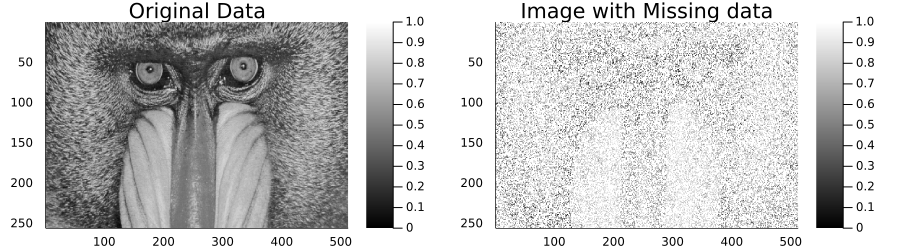

In [7]:
# Example from TestImages package
img = testimage("mandrill")

# Flatten the image to grayscale and select a subset of the image
imgg = Float64.(Gray.(img))
rows, columns = (256, 512)
N = rows*columns

mat = convert(Array{Float64}, imgg)[1:rows,1:columns]

println("There are $((rows - 2) * (columns - 2)) interior nodes, and $(2 * rows + 2 * columns - 2) boundary nodes.")

No_of_nodes_discarded = 100000

println("We discard $(100.0 * No_of_nodes_discarded / N) percent of the data.")

discard = randperm(N)[1:No_of_nodes_discarded]

holeyimage1 = copy(mat)
holeyimage1[discard] .= 1

p1 = heatmap(mat, title = "Original Data", yflip = true, 
              c = :bone, clims = (0.0, 1.0))
p2 = heatmap(holeyimage1, title = "Image with Missing data", yflip = true, 
              c = :bone, clims = (0.0, 1.0))

plot(p1, p2, layout = (1,2), size = (900, 250))

# Reconstruction using Matern and Laplace interpolations

In [9]:
h = k = 1.0
restored_img_laplace = matern_2d_grid(mat, discard, 1, 0.0)
restored_img_matern = matern_2d_grid(mat, discard, 2, 0.0)

256×512 Array{Float64,2}:
 0.57974   0.545428  0.48583   0.420901  …  0.443137  0.431107  0.41403
 0.579187  0.541964  0.473349  0.404858     0.406776  0.394898  0.37604
 0.574881  0.536313  0.445613  0.33943      0.364926  0.345098  0.318624
 0.554657  0.533333  0.427373  0.188235     0.331978  0.294118  0.27451
 0.482739  0.511204  0.517647  0.196078     0.343166  0.313725  0.338514
 0.321569  0.36779   0.482838  0.323668  …  0.420134  0.453785  0.503295
 0.148141  0.2       0.52549   0.452706     0.536827  0.581798  0.643137
 0.138208  0.242471  0.497755  0.6          0.643218  0.595864  0.541176
 0.152214  0.236293  0.384515  0.458824     0.624558  0.584284  0.544496
 0.14902   0.201918  0.280988  0.340749     0.547355  0.538632  0.533333
 0.129412  0.18011   0.223529  0.267823  …  0.447265  0.461241  0.466402
 0.154931  0.221338  0.305882  0.257192     0.355502  0.401742  0.407428
 0.140871  0.192212  0.233476  0.186996     0.301961  0.42049   0.403922
 ⋮                          

# Reconstruction Errors

In [10]:
error_lap = abs.(restored_img_laplace .- mat)
error_mat = abs.(restored_img_matern .- mat)

rel_error_lap = abs.((restored_img_laplace .- mat) ./ mat)
rel_error_mat = abs.((restored_img_matern .- mat) ./ mat);

# Plotting and Saving

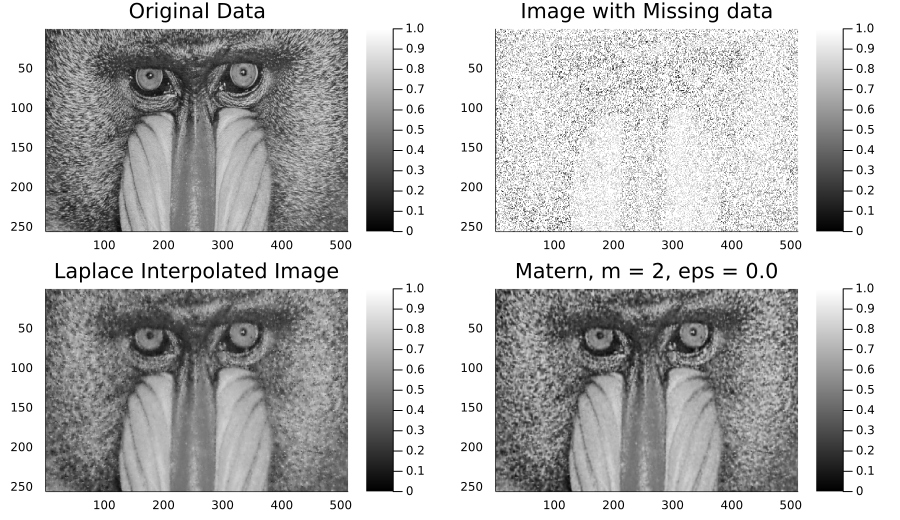

In [11]:
p3 = heatmap(restored_img_laplace, title = "Laplace Interpolated Image", yflip = true, 
              c = :bone, clims = (0.0, 1.0))
p4 = heatmap(restored_img_matern, title = "Matern, m = 2, eps = 0.0", yflip = true, 
              c = :bone, clims = (0.0, 1.0))
plot(p1, p2, p3, p4, layout = (2, 2), legend = false, size = (900, 520))

# png("Mandrill_Random.png")

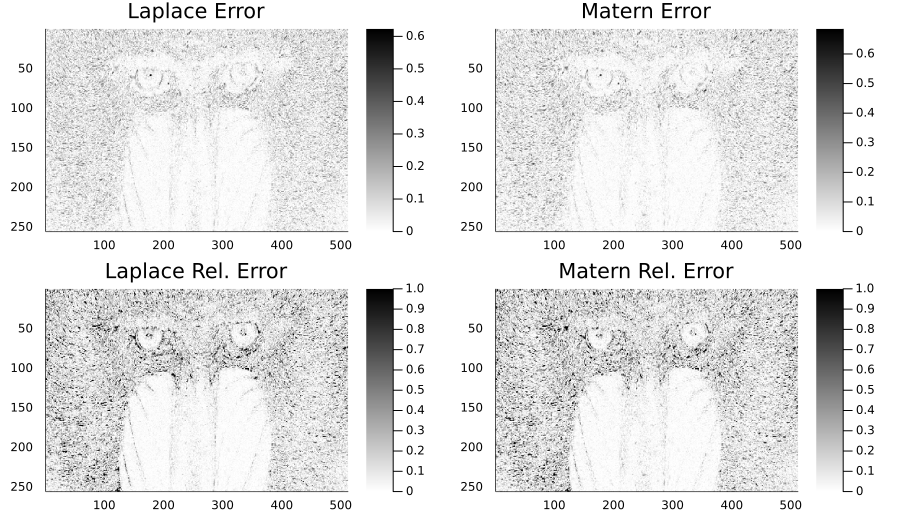

In [12]:
plot1 = heatmap(error_lap, c = :binary, yflip = true, title = "Laplace Error", pointsize = 15)
plot2 = heatmap(error_mat, c = :binary, yflip = true, title = "Matern Error", pointsize = 15)

plot3 = heatmap(rel_error_lap, yflip = true, title = "Laplace Rel. Error", pointsize = 15,
                c = :binary, clims = (0.0, 1.0))
plot4 = heatmap(rel_error_mat, yflip = true, title = "Matern Rel. Error", pointsize = 15,
                c = :binary, clims = (0.0, 1.0))

plot(plot1, plot2, plot3, plot4, layout = (2, 2), legend = false, size = (900, 520))
# png("Mandrill_Random_Errors.png")

# Remove islands of data

In [27]:
cent = [(100, 200), (200, 100)]
rad = 20*ones(Int64, 2)

discard2 = punch_holes_2D(cent, rad, rows, columns)

2514-element Array{Int64,1}:
 45924
 46174
 46175
 46176
 46177
 46178
 46179
 46180
 46181
 46182
 46183
 46184
 46185
     ⋮
 30404
 30405
 30406
 30407
 30408
 30409
 30410
 30411
 30412
 30413
 30414
 30664

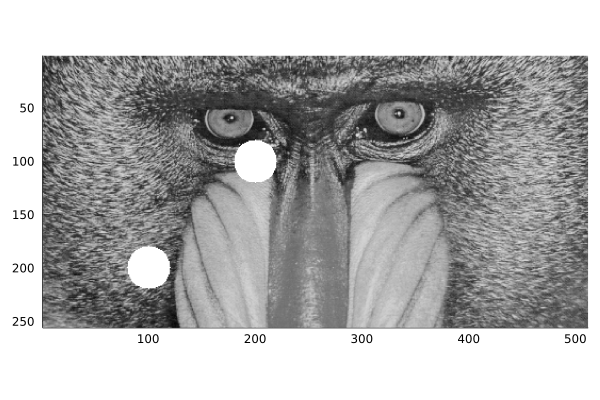

In [14]:
holeyimage = copy(mat)
holeyimage[discard2] .= 1.0
Plots.plot(Gray.(holeyimage))

## Interpolate in small chunks around the punches

The polyharmonic spline is so dense that it does not run. The only way it will run is if we break the problem down.

In [17]:
# code from https://github.com/lstagner/PolyharmonicSplines.jl
include("polyharmonic_splines.jl")

function tps_interpolate(cent, rad, holeyimage)
    xarray = Float64[]
    yarray = Float64[]
    zarray = Float64[]
    clen = length(cent)
    for (i,c) in enumerate(cent)
        for x in (c[1] .- rad[i]):(c[1] .+ rad[i])
            for y in (c[2] .- rad[i]):(c[2] .+ rad[i])
                if((x - c[1])^2 + (y - c[2])^2 > rad[i]^2)
                    xarray = append!(xarray, x)
                    yarray = append!(yarray, y)
                    zarray = append!(zarray, mat[y,x])
                end
            end
        end
    end
    S2 = PolyharmonicSpline(2, [xarray yarray], zarray)
    holeyimage_copy = copy(holeyimage)
    for (i,c) in enumerate(cent)
        x = ones(2*rad[i] + 1)*((c[1]-rad[i]):(c[1]+rad[i]))'
        xx = reshape(x,(2*rad[i] + 1)^2)
        y = ((c[2]-rad[i]):(c[2]+rad[i]))*ones(2*rad[i] + 1)'
        yy = reshape(y,(2*rad[i] + 1)^2)
        zz = interpolate(S2,xx,yy)
        zz_reshape = reshape(zz, (2*rad[i] + 1), (2*rad[i] + 1))
        count = 1
        for k in (c[1]-rad[i]):(c[1]+rad[i])
            for j in (c[2] - rad[i]):(c[2] + rad[i])
                holeyimage_copy[j,k] = zz[count]
                count += 1
            end
        end
    end
    return holeyimage_copy
end
    

@benchmark begin
    tps_interpolate(cent, rad, holeyimage)
end


BechmarkTools.Trial: 6 samples with 1 evaluations.
 Range (min … max):  810.318 ms …    1.147 s  ┊ GC (min … max): 10.78% … 33.66%
 Time  (median):     831.936 ms               ┊ GC (median):    12.27%
 Time  (mean ± σ):   880.715 ms ± 130.920 ms  ┊ GC (mean ± σ):  16.57% ±  8.94%

  ██ ██ █                                                     ██ 
  ██▁██▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  810 ms           Histogram: frequency by time          1.15 s <

 Memory estimate: 1.22 GiB, allocs estimate: 12869356.

In [39]:
function foo(holeyimage, cent, rad)
    holeyimage_copy_m = copy(holeyimage)
    for i = 1:length(cent)
        indx = (cent[i][1]-rad[i]):(cent[i][1]+rad[i])
        indy = (cent[i][2]-rad[i]):(cent[i][2]+rad[i])
        num = (2*rad[i] + 1)
        discard = punch_holes_2D([(rad[i] + 1, rad[i] + 1)], rad[i], num, num)
        holeyimage_copy_m[indx, indy] = matern_2d_grid(mat[indx, indy], discard, 2, 0.0, 1.0, 1.0) 
    end
    return holeyimage_copy_m
end

@benchmark begin
    foo(holeyimage, cent, rad)
end

BechmarkTools.Trial: 444 samples with 1 evaluations.
 Range (min … max):   9.802 ms … 19.908 ms  ┊ GC (min … max): 0.00% … 15.67%
 Time  (median):     10.946 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   11.249 ms ±  1.212 ms  ┊ GC (mean ± σ):  3.41% ±  6.22%

    ▂▂▅▄▆▅▁▁▁▆▃▃▁█  ▁                                          
  ▆▇███████████████▅█▆▄▄▄▄▇▂▅▄▃▄▄▃▄▄▄▄▃▃▄▄▃▄▃▃▃▂▃▃▁▂▁▁▁▁▁▂▁▁▂ ▄
  9.8 ms          Histogram: frequency by time        15.2 ms <

 Memory estimate: 12.83 MiB, allocs estimate: 9256.

## Comparison of errors between Thin plate spline and Matern Interpolation

In [40]:
holeyimage_copy_m = foo(holeyimage, cent, rad);

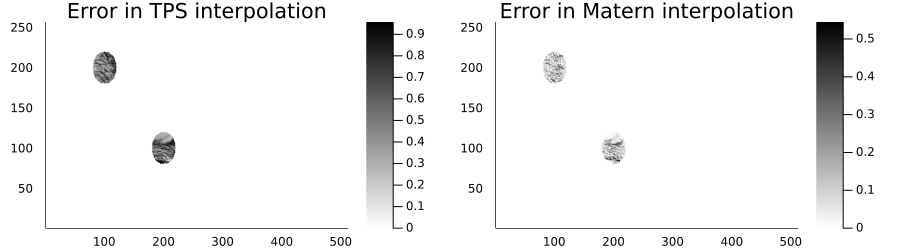

In [41]:
Error_TPS = abs.(mat .- holeyimage)
Error_Matern = abs.(mat .- holeyimage_copy_m)

plot1 = heatmap(Error_TPS, c = :binary, title = "Error in TPS interpolation")
plot2 = heatmap(Error_Matern, c = :binary, title = "Error in Matern interpolation")

plot(plot1, plot2, layout = (1, 2), legend = false, size = (900, 250))
# png("Mandrill_Errors.png")